# Post-Game Shot Charts

Create Instagram-ready shot chart visualizations from the Bulls' most recent game:
1. **Team Shot Chart** - All Bulls shots with zone efficiency callouts
2. **Top Scorer Shot Chart** - Leading scorer's shots isolated

In [1]:
# Setup - Import libraries and configure
import sys
from pathlib import Path

# Add parent directory to path so we can import bulls
sys.path.insert(0, str(Path().absolute().parent))

from bulls import data, analysis, viz
from bulls.config import OUTPUT_DIR
import pandas as pd
import matplotlib.pyplot as plt

# Configure matplotlib for better display in notebooks
plt.style.use('default')
%matplotlib inline

print("Bulls Analytics loaded")
print(f"Output directory: {OUTPUT_DIR}")

Bulls Analytics loaded
Output directory: /Users/meltangonan/projects/bulls-analytics/output


## Step 1: Fetch Game Data

Get the latest game info, box score, and identify the top scorer.

In [2]:
# Get latest game
game = data.get_latest_game()
print(f"Game: {game['matchup']} ({game['date']})")
print(f"Result: {game['result']} {game['bulls_score']}")
print(f"Plus/Minus: {game['plus_minus']:+d}")
print(f"Game ID: {game['game_id']}")

# Get box score
box = data.get_box_score(game['game_id'])
performers = analysis.top_performers(box)
top_scorer = performers[0]
print(f"\nTop scorer: {top_scorer['name']} - {top_scorer['points']} pts")
print(f"Player ID: {top_scorer['player_id']}")

Game: CHI vs. LAC (2026-01-20)
Result: W 138
Plus/Minus: +28
Game ID: 0022500614

Top scorer: Coby White - 27 pts
Player ID: 1629632


## Step 2: Fetch Shot Data

Get all Bulls shots from the game, then filter for the top scorer.

In [3]:
# Get team shots for the last game
team_shots = data.get_team_shots(last_n_games=1)
game_shots = team_shots[team_shots['game_id'] == game['game_id']]
print(f"Total shots: {len(game_shots)}")
print(f"Makes: {game_shots['shot_made'].sum()} ({game_shots['shot_made'].mean()*100:.1f}%)")

# Top scorer's shots
player_shots = game_shots[game_shots['player_id'] == top_scorer['player_id']]
print(f"\n{top_scorer['name']} shots: {len(player_shots)}")
print(f"Makes: {player_shots['shot_made'].sum()} ({player_shots['shot_made'].mean()*100:.1f}% FG)")

Total shots: 92
Makes: 52 (56.5%)

Coby White shots: 16
Makes: 9 (56.2% FG)


## Step 3: Calculate Zone Stats

Break down shooting efficiency by zone for callout text.

In [4]:
# Team zone stats
zone_stats = analysis.game_zone_stats(game_shots)
print("Team Zone Stats:")
for zone, stats in sorted(zone_stats.items()):
    print(f"  {zone}: {stats['formatted']}")

# Top scorer zone stats
player_zone_stats = analysis.game_zone_stats(player_shots)
print(f"\n{top_scorer['name']} Zone Stats:")
for zone, stats in sorted(player_zone_stats.items()):
    print(f"  {zone}: {stats['formatted']}")

Team Zone Stats:
  Above the Break 3: 24/39 (61.5%)
  In The Paint (Non-RA): 7/11 (63.6%)
  Left Corner 3: 0/1 (0.0%)
  Mid-Range: 0/3 (0.0%)
  Restricted Area: 20/31 (64.5%)
  Right Corner 3: 1/7 (14.3%)

Coby White Zone Stats:
  Above the Break 3: 6/10 (60.0%)
  Restricted Area: 3/6 (50.0%)


## Step 4: Team Shot Chart

Create the team-wide shot chart with zone efficiency callouts.

Annotations: [{'text': '20/31 at the rim', 'position': 'bottom_left'}, {'text': '25/47 from 3', 'position': 'top_right'}]


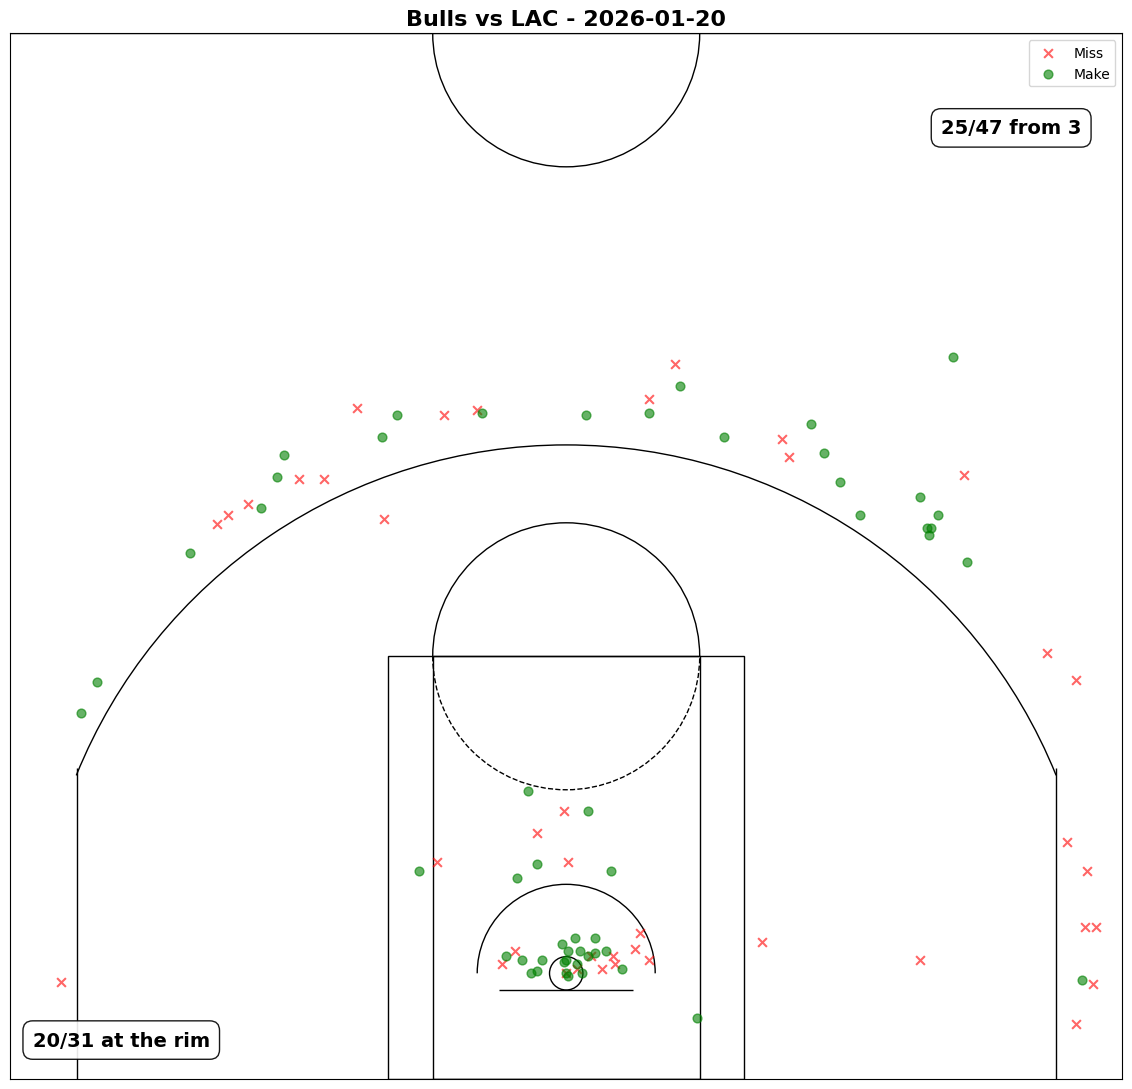

In [5]:
# Build annotations - customize these based on key stats!
team_annotations = []

# Add Restricted Area stat if available
if 'Restricted Area' in zone_stats:
    ra = zone_stats['Restricted Area']
    team_annotations.append({
        'text': f"{ra['made']}/{ra['attempted']} at the rim",
        'position': 'bottom_left'
    })

# Add 3-point stats
three_pt_made = sum(zone_stats.get(z, {}).get('made', 0) for z in ['Above the Break 3', 'Left Corner 3', 'Right Corner 3'])
three_pt_att = sum(zone_stats.get(z, {}).get('attempted', 0) for z in ['Above the Break 3', 'Left Corner 3', 'Right Corner 3'])
if three_pt_att > 0:
    team_annotations.append({
        'text': f"{three_pt_made}/{three_pt_att} from 3",
        'position': 'top_right'
    })

print(f"Annotations: {team_annotations}")

# Create chart
team_fig = viz.shot_chart(
    game_shots,
    title=f"Bulls vs {game['opponent']} - {game['date']}",
    annotations=team_annotations
)

plt.show()

## Step 5: Top Scorer Shot Chart

Create a shot chart focused on the game's leading scorer.

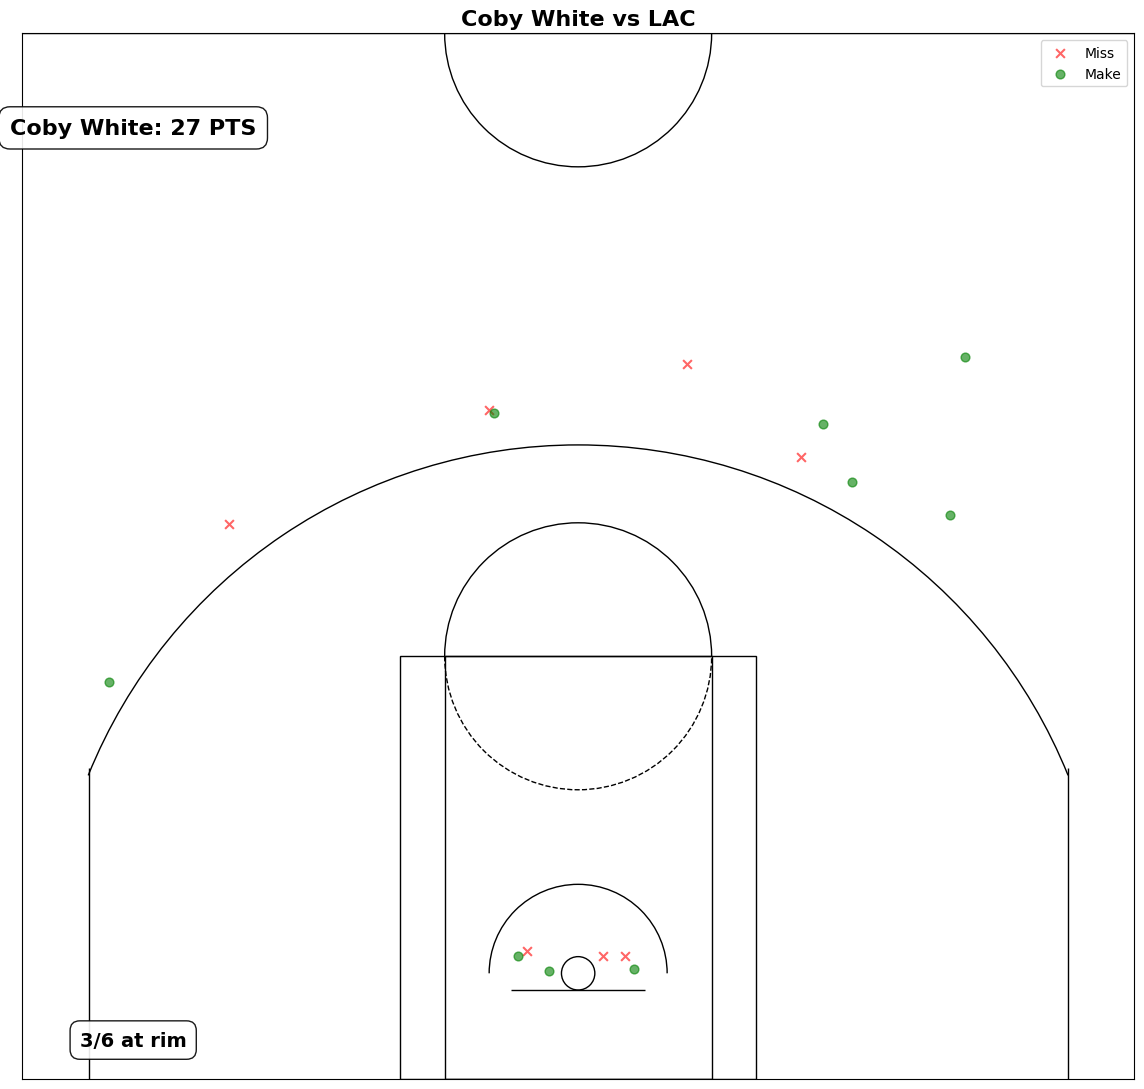

In [6]:
# Build player annotations
player_annotations = [
    {
        'text': f"{top_scorer['name']}: {top_scorer['points']} PTS",
        'position': 'top_left',
        'fontsize': 16
    }
]

# Add player's key zone stat
if 'Restricted Area' in player_zone_stats:
    ra = player_zone_stats['Restricted Area']
    player_annotations.append({
        'text': f"{ra['made']}/{ra['attempted']} at rim",
        'position': 'bottom_left'
    })

# Create chart
player_fig = viz.shot_chart(
    player_shots,
    title=f"{top_scorer['name']} vs {game['opponent']}",
    annotations=player_annotations
)

plt.show()

## Step 6: Save Charts (Optional)

Uncomment and run to save the charts to the output directory.

In [7]:
# Uncomment to save charts
# OUTPUT_DIR.mkdir(exist_ok=True)

# team_path = OUTPUT_DIR / f"team_shots_{game['date']}.png"
# team_fig.savefig(team_path, dpi=300, bbox_inches='tight', facecolor='white')
# print(f"Saved: {team_path}")

# player_path = OUTPUT_DIR / f"{top_scorer['name'].replace(' ', '_')}_shots_{game['date']}.png"
# player_fig.savefig(player_path, dpi=300, bbox_inches='tight', facecolor='white')
# print(f"Saved: {player_path}")